In [1]:
#library imports
import math
from collections import namedtuple
import numpy as np
from numpy.linalg import inv
from sympy import symbols
import matplotlib.pyplot as plt

In [2]:
#some boilerplate code
x = symbols('x')
Equation = namedtuple('Equation',('a','b'))
Conditions = namedtuple('Conditions',('x0','xn','y0','yn','z0','zn','h'))

In [3]:
%%latex
\begin{align}
y^{4} + 81y = 81x^2\\
x \in (0, 1) \\
y(0) = 0\\
y(1) = 1\\
y''(0) = 0\\
y''(1) = 1\\
\end{align}

<IPython.core.display.Latex object>

In [4]:
def FiniteDiffSolver(eq, cond, verbose=True):
    n = int(np.ceil((cond.xn - cond.x0)/cond.h))
    a, b, c, d = np.zeros((n-2, 2, 2)), np.zeros((n-1, 2, 2)), np.zeros((n-2, 2, 2)), np.zeros((n-1, 2))
    #A
    b[0] = np.array([[-2/cond.h**2, -1], [eq.a.subs(x, cond.x0 + cond.h), -2/cond.h**2]])
    c[0] = np.array([[1/cond.h**2, 0], [0, 1/cond.h**2]])
    b[n-2] = np.array([[-2/cond.h**2, -1], [eq.a.subs(x, cond.xn - cond.h), -2/cond.h**2]])
    a[n-3] = np.array([[1/cond.h**2, 0], [0, 1/cond.h**2]])
    #d
    d[0] = np.array([0, eq.b.subs(x, cond.x0 + cond.h)]) -\
    np.array([[1/cond.h**2, 0], [0, 1/cond.h**2]]).dot(np.array([cond.y0, cond.z0]))
    d[n-2] = np.array([0, eq.b.subs(x, cond.xn - cond.h)]) -\
    np.array([[1/cond.h**2, 0], [0, 1/cond.h**2]]).dot(np.array([cond.yn, cond.zn]))
    for i, xi in enumerate(np.arange(cond.x0 + 2*cond.h, cond.xn - cond.h, cond.h),\
                           start=1):
        a[i-1] = np.array([[1/cond.h**2, 0], [0, 1/cond.h**2]])
        b[i] = np.array([[-2/cond.h**2, -1], [eq.a.subs(x, xi), -2/cond.h**2]])
        c[i] = np.array([[1/cond.h**2, 0], [0, 1/cond.h**2]])
        d[i] = np.array([0, eq.b.subs(x, xi)])
        
    if verbose:
        print("A={}, B={}, C={}, D={}".format(a,b,c,d))
        
    return (a,b,c,d)

In [5]:
def Thomas_Algorithm(coeff, cond):
    a, b, c, d = coeff
    n = int(np.ceil((cond.xn - cond.x0)/cond.h))
    c1 = np.zeros((n-2, 2, 2))
    d1 = np.zeros((n-1, 2))
    c1[0] = inv(b[0]).dot(c[0])
    d1[0] = inv(b[0]).dot(d[0])
    for i in range(1,n-2):
        t1 = b[i]-a[i-1].dot(c1[i-1])
        c1[i] = inv(t1).dot(c[i])
        d1[i] = inv(t1).dot(d[i] - a[i-1].dot(d1[i-1]))
    d1[n-2] = inv(b[n-2] - a[n-3].dot(c1[n - 3])).dot(d[n-2] - a[n-3].dot(d1[n-3]))
    #d1[n-2] = (d[n-2] - a[n-3] * d1[n-3])/(b[n-2] - a[n-3]*c1[n-3])
    def backsubstitution(c,d):
        y = np.zeros_like(d)
        y[-1] = d[-1]
        cache = y[-1]
        for i in reversed(range(d.shape[0]-1)):
            y[i] = d[i] - c[i].dot(cache)
            cache = y[i]
        return y
    fin_y = backsubstitution(c1,d1)
    y = np.append(fin_y.T[0], cond.yn)
    y = np.append(cond.y0, y)
    return y

In [6]:
eq = Equation(81 + 0.0*x,81*x**2)
cond = Conditions(0, 1, 0, 0, 0, 0, 0.1)
ans = FiniteDiffSolver(eq, cond, verbose=False)
y1 = Thomas_Algorithm(ans, cond)
x_range1 = np.arange(cond.x0, cond.xn+cond.h, cond.h)
eq = Equation(81 + 0.0*x,81*x**2)
cond = Conditions(0, 1, 0, 0, 0, 0, 0.05)
ans = FiniteDiffSolver(eq, cond, verbose=False)
y2 = Thomas_Algorithm(ans, cond)
x_range2 = np.arange(cond.x0, cond.xn+cond.h, cond.h)
eq = Equation(81 + 0.0*x,81*x**2)
cond = Conditions(0, 1, 0, 0, 0, 0, 0.01)
ans = FiniteDiffSolver(eq, cond, verbose=False)
y3 = Thomas_Algorithm(ans, cond)
x_range3 = np.arange(cond.x0, cond.xn+cond.h, cond.h)

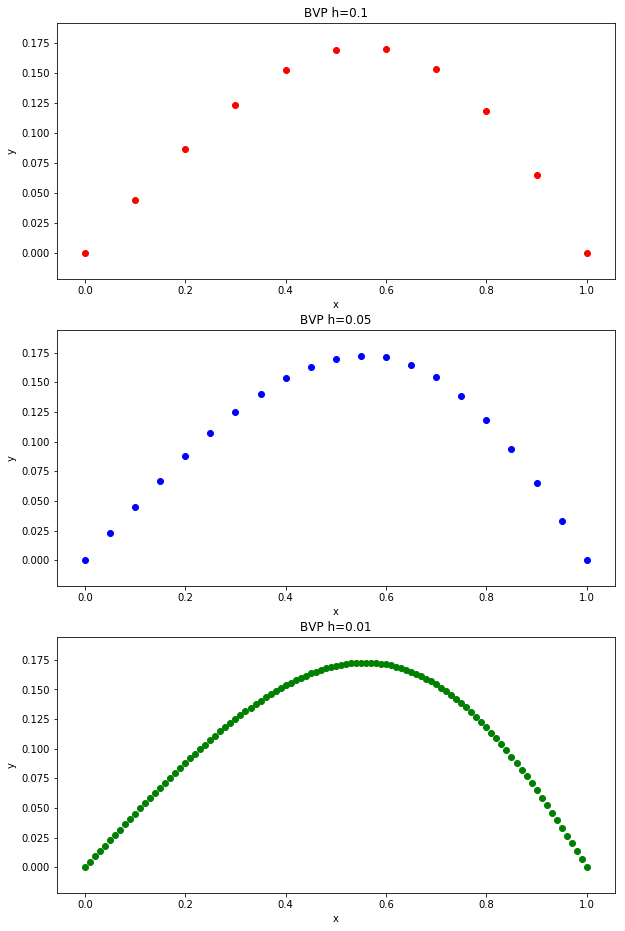

In [8]:
t1 = np.arange(cond.x0, cond.xn, 0.001)
fig = plt.figure(figsize=(10, 16))
ax = fig.add_subplot(311)
ax.set(title="BVP h=0.1", xlabel="x", ylabel="y")
ax.scatter(x_range1, y1, color='red')
ax = fig.add_subplot(312)
ax.set(title="BVP h=0.05", xlabel="x", ylabel="y")
ax.scatter(x_range2, y2, color='blue')
ax = fig.add_subplot(313)
ax.set(title="BVP h=0.01", xlabel="x", ylabel="y")
ax.scatter(x_range3, y3, color='green')
ax.plot()
fig.show()